# Parametrised Boolean Networks in AEON.py

AEON.py offers basic functionality for working with Boolean networks. In particular, it supports **three major formats** (`.bnet`, `.sbml`, and `.aeon`), can perform basic **integrity checks** (e.g. that an update function only uses variables that are actually declared as regulators, etc.), and can be used to run simple operations on the regulatory graph (like decomposition into **strongly connected components** or detection of **feedback vertex sets**).

However, there are two features in particular that (as of now) are uniquely implemented in this library:
 
 - Support for fully symbolic exploration of the asynchronous dynamics of a Boolean network (using `AsynchronousGraph`). With this functionality, you can typically explore the dynamics of networks with tens or hundreds of variables without suffering from state space explosion.
 - Support for "parametrised" (or "partially specified") networks, where the transitions possibly depend on unknown (uninterpreted) functions. For example, this means that if your data isn't sufficient to actually produce a single "correct" network, you can automatically work with a collection of networks with different dynamical constraints.

In [1]:
from biodivine_aeon import *

If you have an existing model that you want to work with, you can load it right away as a Boolean network. Here, we will use (for demonstration) a very simple model with 5 variables:

In [2]:
from pathlib import Path

model_string = txt = Path('g2a.sbml').read_text()
g2a = BooleanNetwork.from_sbml(model_string)

# You can also use
# BooleanNetwork.from_bnet(...)
# BooleanNetwork.from_aeon(...)

g2a.variable_count()

5

Similarly, if you already have a Boolean network, you can easily print it to one of these formats. Just keep in mind that every format has slightly different capabilities (for example, `bnet` does not keep track of the underlying regulatory graph, so this information will be lost).

In [3]:
print(g2a.to_bnet())

targets,factors
CcrM, ((CtrA & !CcrM) & !SciP)
CtrA, (((CtrA & !CtrA) | ((((!CtrA & GcrA) & !CcrM) & !SciP) & (CtrA | !CtrA))) | ((CtrA & !CcrM) & !SciP))
DnaA, (((CtrA & !GcrA) & !DnaA) & CcrM)
GcrA, (!CtrA & DnaA)
SciP, (CtrA & !DnaA)



In [4]:
# We can also use other colomoto tools to visualise the network:
import biolqm
import ginsim

lqm = biolqm.load("g2a.sbml")
lrg = biolqm.to_ginsim(lqm)
ginsim.show(lrg)

ModuleNotFoundError: No module named 'biolqm'

### Regulatory Graphs

Now, if you want to create your network in code, you usually have to first create its `RegulatoryGraph`. A regulatory graph consists simply of variables connected using regulation edges. Each regulation edge can have a monotonicity (sign; `+` or `-`), and can be essential (`True` or `False`). Monotonicity means that once we try to assign actual Boolean function to this regulation, it must be non-decreasing or non-increasing in the input coresponding to the regulator. Meanwhile, an essential regulation must have an impact on the regulated variable, while non-essential may simply ignore the regulation.

In [5]:
# To create a regulatory graph, you give it a list of variables that you want to create
rg = RegulatoryGraph(["a", "b", "c"])
rg.variables()

[VariableId(0), VariableId(1), VariableId(2)]

Notice that the variables in the regulatory graph are identified using `VariableId` objects. This is mostly to avoid working with name strings outside of the Boolean network or regulatory graph in Rust. However, most of our Python API should happily accept both a variable name or a `VariableId` object.

You can always translate between the two easily:

In [6]:
# Note that rg.variable_names() also exists.
rg.get_variable_name(rg.variables()[1])

'b'

In [7]:
rg.find_variable("c")

VariableId(2)

Now, we can start adding regulations to our graph. Notice that the sign and essentiality always need to be specified. To identify variables, we can use both names and numeric IDs.

In [8]:
# You can also use rg.ensure_regulation to update existing regulations.

rg.add_regulation({ "source": "a", "target": "b", "sign": "+", "essential": True })

rg.add_regulation({ "source": "b", "target": "c", "sign": None, "essential": False })
rg.add_regulation({ "source": "b", "target": "a", "sign": None, "essential": False })

rg.add_regulation({ "source": "a", "target": "a", "sign": None, "essential": False }) # autoregulations
rg.add_regulation({ "source": "c", "target": "c", "sign": None, "essential": False })

rg.regulations()

[{'source': VariableId(0),
  'target': VariableId(1),
  'essential': True,
  'sign': '+'},
 {'source': VariableId(1),
  'target': VariableId(2),
  'essential': False,
  'sign': None},
 {'source': VariableId(1),
  'target': VariableId(0),
  'essential': False,
  'sign': None},
 {'source': VariableId(0),
  'target': VariableId(0),
  'essential': False,
  'sign': None},
 {'source': VariableId(2),
  'target': VariableId(2),
  'essential': False,
  'sign': None}]

In [9]:
rg.find_regulation("a", "b")

{'source': VariableId(0),
 'target': VariableId(1),
 'essential': True,
 'sign': '+'}

Once we have a graph, we can perform some basic exploration of its structure:

In [10]:
rg.predecessors("b")

{VariableId(0)}

In [11]:
rg.successors("b")

{VariableId(0), VariableId(2)}

In [12]:
rg.backward_reachable("b")

{VariableId(0), VariableId(1)}

In [13]:
rg.forward_reachable("b")

{VariableId(0), VariableId(1), VariableId(2)}

We can even run a simple SCC decomposition algorithm which will reveal variables that are influencing each other. Here, we know that `a` and `b` have a cycle together, and `c` is only influenced by `b`.

In [14]:
rg.strongly_connected_components()

[{VariableId(2)}, {VariableId(0), VariableId(1)}]

Each Boolean network inherits from a regulatory graph, hence we can use the same methods:

In [15]:
g2a.strongly_connected_components()

[{VariableId(0), VariableId(1), VariableId(2), VariableId(3), VariableId(4)}]

In this case, we see that the g2a network has only one component, consisting of all its variables.

### Update Functions and Parameters

A Boolean network is essentially a regulatory graph with update functions. However, as we mentioned above, our Boolean networks can actually contain functions that are either unknown, or partially defined using logical parameters and uninterpreted Boolean functions.

In [16]:
# Create a Boolean network with a fixed regulatory graph
bn = BooleanNetwork(rg)

# Initially, all update functions are undefined:
print(bn.get_update_function("a"))

None


We can still work with such a network, but in this case, our implementation of `AsynchronousGraph` would consider **every possible** update function for every variable (as long as it satisfies requirements on regulation observability and monotonicity). That is mostly fine for such a small network, but would be impossible to solve for networks with hundreds of variables and thousands of regulations.

To specify exact update functions, we can simply provide a Boolean expression which describes the function:

In [17]:
bn.set_update_function("a", "b & !a")
str(bn.get_update_function("a"))

'b & !a'


Note that `b -> a` is an activation, hence `b` must "positively" influence the outcome of this update function (although, whether this holds is not verified by the Boolean network, only once we try to create an asynchronous graph for it).

If we don't know the whole function, we can simply leave it as `None`. However, we can also use "basic" logical parameters (constant unknown values) and uninterpreted functions to make the function partially defined:

In [18]:
# Add a basic parameter. Arity 0 means the parameter is a constant.
bn.add_explicit_parameter("p1", 0)

# Update function for `c` will depend on `c` only when `p1` is set.
bn.set_update_function("c", "b & (p1 => c)")

# Parameter of arity one is a Boolean function with one argument.
bn.add_explicit_parameter("p2", 1)

# We can use it for example like this:
str(bn.set_update_function("c", "b & p2(c)"))

'b & (p1 => c)'

Here, update function for `c` can be `b & c`, `b & !c`, `b & true`, or `b & false`, depending on `p2`. This is because the autoregulation has no monotonicity (hence `c` can appear positively or negatively) and may not be observable (`c` may not appear at all, in which case `p2` is a constant function).

This syntax can be in particular useful when we deal with variables that have multiple regulators:

In [19]:
str(g2a.get_update_function("CtrA"))

'false | (!CtrA & GcrA & !CcrM & !SciP & true) | (CtrA & !CcrM & !SciP)'

In [20]:
g2a.add_explicit_parameter("f1", 2)
g2a.set_update_function("CtrA", "CtrA & !SciP & f1(CcrM, GcrA)")

str(g2a.get_update_function("CtrA"))

'CtrA & !SciP & f1(CcrM, GcrA)'

Here, we clearly specify that the value of `CtrA` has a known dependence on `CtrA` and `SciP`, but unknown on `CcrM` and `GcrA`.

### Symbolic Asynchronous Graph

To further explore the network's dynamics, we can use its symbolic asynchronous graph. Although, this feature will mostly be used for building standalone algorithms and not directly used within a notebook.

In [21]:
try:
    graph = AsynchronousGraph(g2a)
except Exception as e:
    print(e)

# There are 32 states and 2 colors (two possible instantiations of function `f1`)
graph.mk_unit_colored_vertices()

ColoredVertexSet(cardinality=64, colors=2, vertices=32, symbolic_size=9)

Here, the constructor will check whether the Boolean network contains some inconsistencies: for example, an unused parameter, unused observable regulation, or update functions that do not satisfy the regulation constraints (activation in place of inhibition, etc.).

The graph works with three types of sets: `ColorSet`, `VertexSet` and `ColoredVertexSet`. A color set contains possible valuations of logical parameters and uninterpreted functions. So, each member of a color set fully specifies a Boolean network. If there are no parameters, this set can be only "empty" or "1". Similarly, a vertex set contains vertices of the graph. Finally, a colored vertex set contains pairs of colors and vertices, meaning that for each color, we can have a different set of vertices (or, similarly, for each vertex a different color). This type of set can be then used to represent a set of vertices that is different for different parametrisation.

In [22]:
a_color = graph.mk_unit_colors().pick_singleton()
a_color.cardinality()

1

A set of vertices can be also "dumped" to a list or iterated, but keep in mind that the set can be huge and will easily exhaust memory for models with more than 10 variables. Always check the size of your set using `cardinality` first.

In [23]:
vertices = graph.mk_subspace_vertices({ "SciP": False })
for v in vertices:
    print(v)

VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 0, 'GcrA': 0, 'SciP': 0})
VertexModel({'CcrM': 1, 'CtrA': 0, 'DnaA': 0, 'GcrA': 0, 'SciP': 0})
VertexModel({'CcrM': 0, 'CtrA': 1, 'DnaA': 0, 'GcrA': 0, 'SciP': 0})
VertexModel({'CcrM': 1, 'CtrA': 1, 'DnaA': 0, 'GcrA': 0, 'SciP': 0})
VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 1, 'GcrA': 0, 'SciP': 0})
VertexModel({'CcrM': 1, 'CtrA': 0, 'DnaA': 1, 'GcrA': 0, 'SciP': 0})
VertexModel({'CcrM': 0, 'CtrA': 1, 'DnaA': 1, 'GcrA': 0, 'SciP': 0})
VertexModel({'CcrM': 1, 'CtrA': 1, 'DnaA': 1, 'GcrA': 0, 'SciP': 0})
VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 0, 'GcrA': 1, 'SciP': 0})
VertexModel({'CcrM': 1, 'CtrA': 0, 'DnaA': 0, 'GcrA': 1, 'SciP': 0})
VertexModel({'CcrM': 0, 'CtrA': 1, 'DnaA': 0, 'GcrA': 1, 'SciP': 0})
VertexModel({'CcrM': 1, 'CtrA': 1, 'DnaA': 0, 'GcrA': 1, 'SciP': 0})
VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 1, 'GcrA': 1, 'SciP': 0})
VertexModel({'CcrM': 1, 'CtrA': 0, 'DnaA': 1, 'GcrA': 1, 'SciP': 0})
VertexModel({'CcrM': 0, 'CtrA': 1,

Finally, we can use the graph to compute successors and predecessors for colored sets of vertices. Using this operation, we can implement more complex algorithms, like SCC decomposition or safety analysis.

In [24]:
universe = graph.mk_unit_vertices()
while not universe.is_empty():
    one_state = universe.pick_singleton()
    print("Picked:", next(iter(one_state)))
    reachable = one_state.extend_with_colors(graph.mk_unit_colors())
    for i in range(10):
        step = graph.post(reachable)
        new = step.minus(reachable)
        print(i+1, "Discovered", new.vertices().cardinality(), "using colors", new.colors().cardinality())
        if new.is_empty():
            break
        reachable = reachable.union(new)
    
    print("Total discovered vertices:", reachable.vertices().cardinality())
    universe = universe.minus(reachable.vertices())

Picked: VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 0, 'GcrA': 0, 'SciP': 0})
1 Discovered 0 using colors 0
Total discovered vertices: 1
Picked: VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 0, 'GcrA': 0, 'SciP': 1})
1 Discovered 1 using colors 2
2 Discovered 0 using colors 0
Total discovered vertices: 2
Picked: VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 0, 'GcrA': 1, 'SciP': 0})
1 Discovered 1 using colors 2
2 Discovered 0 using colors 0
Total discovered vertices: 2
Picked: VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 0, 'GcrA': 1, 'SciP': 1})
1 Discovered 2 using colors 2
2 Discovered 1 using colors 2
3 Discovered 0 using colors 0
Total discovered vertices: 4
Picked: VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 1, 'GcrA': 0, 'SciP': 0})
1 Discovered 2 using colors 2
2 Discovered 1 using colors 2
3 Discovered 0 using colors 0
Total discovered vertices: 4
Picked: VertexModel({'CcrM': 0, 'CtrA': 0, 'DnaA': 1, 'GcrA': 0, 'SciP': 1})
1 Discovered 3 using colors 2
2 Discovered 3 using colors 2
3 D

It is also possible to use `var_post` and `var_pre` to only update a specific variable in the network during a transition.

To save the results of the computation, we can use the fact that these sets are all internally represented as BDDs, which we can dump to a string, show as a `.dot`, or save using `pickle`:

In [25]:
reachable_string = reachable.to_bdd().data_string()
reachable_string

'|9,0,0|9,1,1|5,0,1|4,0,2|3,3,0|5,1,0|4,0,5|3,6,0|2,7,4|'

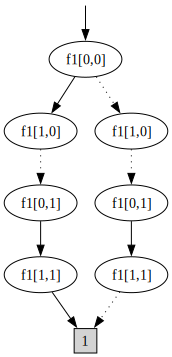

In [26]:
import graphviz

graphviz.Source(reachable.to_bdd().to_dot())

In [27]:
# We need to copy an existing set to preserve all metadata about the model,
# since these are not save in the BDD
reachable_reloaded = ColoredVertexSet(
    graph.symbolic_context(), 
    Bdd(graph.symbolic_context().bdd_variable_set(), reachable_string)
)

# r1 <=> r2 must be a tautology if the sets are equivalent:
reachable_reloaded.to_bdd() == reachable.to_bdd()

True

However, keep in mind that the raw string does not contain any information about the underlying model, and you cannot mix BDD representations between different models!